# MODIS Water Raster Viewing 1.0.0
Version: 09.27.2021

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
LABEL_NAME = 'water'
DATA_TYPE = float
SKLEARN = False
TILE = 'h09v05'

# Testing: Raster testing

In [3]:
DAY = 160
YEAR = 2001
PATH = '/att/nobackup/cssprad1/projects/modis_water/data/test_data/{}/'.format(TILE)

In [9]:
vars_list = [fn for fn in glob.glob(os.path.join(PATH, '*A{}{:03}*.tif'.format(YEAR, DAY)))]
vars_list.sort()
vars_list = vars_list[3:] + vars_list[:3]

## Get dimensions of inputs

In [10]:
vars_list

['/att/nobackup/cssprad1/projects/modis_water/data/test_data/h09v05/MOD09GA.A2001160.h09v05.061.2020061235748-sur_refl_b01_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h09v05/MOD09GA.A2001160.h09v05.061.2020061235748-sur_refl_b02_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h09v05/MOD09GA.A2001160.h09v05.061.2020061235748-sur_refl_b03_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h09v05/MOD09GA.A2001160.h09v05.061.2020061235748-sur_refl_b04_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h09v05/MOD09GA.A2001160.h09v05.061.2020061235748-sur_refl_b05_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h09v05/MOD09GA.A2001160.h09v05.061.2020061235748-sur_refl_b06_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h09v05/MOD09GA.A2001160.h09v05.061.2020061235748-sur_refl_b07_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h09v05/MOD09GA.A200116

In [11]:
vrt_opts = gdal.BuildVRTOptions(separate=True)
dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_opts)
nrows, ncols = dd.RasterYSize, dd.RasterXSize

In [12]:
dd

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x2b68e25d0330> >

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [13]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    imgWhole = {}
    for b in range(len(vars_list)):
        band = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16)
        img[:, b] = band.ravel()
        imgWhole[b+1] = band
    dd = None
    #imgWhole[:, :, len(vars_list)] = ((imgWhole[:, :, 1] - imgWhole[:, :, 0]) / (imgWhole[:, :, 1] + imgWhole[:, :, 0])) * 10000
    #imgWhole[:, :, len(vars_list)+1] = ((imgWhole[:, :, 1] - imgWhole[:, :, 5]) / (imgWhole[:, :, 1] + imgWhole[:, :, 5])) * 10000
    #imgWhole[:, :, len(vars_list)+2] = ((imgWhole[:, :, 1] - imgWhole[:, :, 6]) / (imgWhole[:, :, 1] + imgWhole[:, :, 6])) * 10000
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    return img, imgWhole

In [14]:
im, imWhole = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[  1735   2484    989 ...   1775  -1507   -515]
 [  1735   2484    989 ...   1775  -1507   -515]
 [  1813   2600   1052 ...   1783  -1588   -600]
 ...
 [  9774 -28672   9457 ... -14334  11441  10645]
 [  9735 -28672   9431 ... -14325  11427  10669]
 [  9735 -28672   9431 ... -14325  11427  10669]]
599.04 MB size


In [15]:
imWhole

{1: array([[1735, 1735, 1813, ..., 2149, 2239, 2239],
        [1735, 1735, 1813, ..., 2149, 2239, 2239],
        [1967, 1967, 2024, ..., 2718, 2493, 2493],
        ...,
        [2081, 2081, 5494, ..., 9768, 9774, 9774],
        [3210, 3210, 5494, ..., 9774, 9735, 9735],
        [3210, 3210, 5494, ..., 9774, 9735, 9735]], dtype=int16),
 2: array([[  2484,   2484,   2600, ...,   3240,   3579,   3579],
        [  2484,   2484,   2600, ...,   3240,   3579,   3579],
        [  2749,   2749,   2844, ...,   3812,   3838,   3838],
        ...,
        [  2262,   2262,   5682, ...,   9368, -28672, -28672],
        [  3358,   3358,   5682, ..., -28672, -28672, -28672],
        [  3358,   3358,   5682, ..., -28672, -28672, -28672]], dtype=int16),
 3: array([[ 989,  989, 1052, ..., 1903, 2014, 2014],
        [ 989,  989, 1052, ..., 1903, 2014, 2014],
        [1130, 1130, 1176, ..., 2346, 2211, 2211],
        ...,
        [1886, 1886, 5071, ..., 9479, 9527, 9527],
        [3163, 3163, 5071, ..., 94

In [18]:
bandDict = imWhole
SENZ = 8
SOLZ = 9
STATE = 10
AERO_MASK = 192
CLOUDY = 1
CLOUD_MIXED = 2
CLOUD_SHADOW = 4
CLOUD_INT = 1024

In [49]:
mask = np.where( \
            (bandDict[1] < -100) |
            (bandDict[1] > 16000) |
            (bandDict[2] < -100) |
            (bandDict[2] > 16000) |
            (bandDict[3] < -100) |
            (bandDict[3] > 16000) |
            (bandDict[4] < -100) |
            (bandDict[4] > 16000) |
            (bandDict[5] < -100) |
            (bandDict[5] > 16000) |
            (bandDict[6] < -100) |
            (bandDict[6] > 16000) |
            (bandDict[7] < -100) |
            (bandDict[7] > 16000) |
            

            (bandDict[SENZ] > 4500) |
            (bandDict[SOLZ] > 6500) |
            
            (bandDict[STATE] & AERO_MASK == AERO_MASK) |
                 
            (bandDict[STATE] & CLOUDY == CLOUDY) | 
            
            (bandDict[STATE] & CLOUD_MIXED == CLOUD_MIXED) |
                
            (bandDict[STATE] & CLOUD_SHADOW == CLOUD_SHADOW) |
                
            (bandDict[STATE] & CLOUD_INT == CLOUD_INT),
            1,
            0)

In [50]:
mask.any(),mask.all()

(True, False)

In [52]:
diff = mask == qaMaskMatrix
diff.all()

False

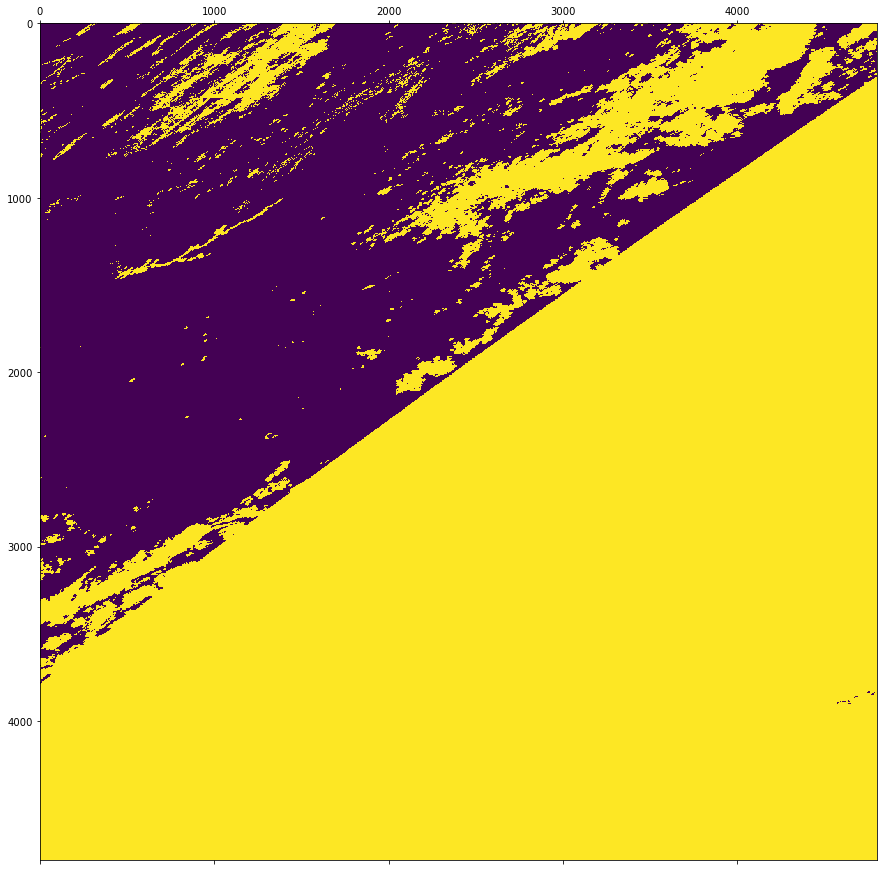

In [53]:
plt.figure(figsize=(15, 15))
plt.matshow(qaMaskMatrix, fignum=1)

In [ ]:
plt.figure(figsize=(15, 15))
plt.matshow(mask, fignum=1)

In [31]:
qaMask = '/att/nobackup/cssprad1/projects/modis_water/data/qa_masks'
waterMask = '/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019'
qa_list = [fn for fn in glob.glob(os.path.join(qaMask, '*A{}{:03}.{}*bad_good_mask.tif'.format(YEAR, DAY, TILE)))]
water_list = [fn for fn in glob.glob(os.path.join(waterMask, '*{}*.tif'.format(TILE)))]
qa_mask = qa_list[0]
water_mask = water_list[0]
print(water_mask)
print(qa_mask)
ds = gdal.Open(qa_mask, gdal.GA_ReadOnly)
waterMask = gdal.Open(water_mask, gdal.GA_ReadOnly)
qaMaskMatrix = ds.GetRasterBand(1).ReadAsArray()
waterMaskMatrix = waterMask.GetRasterBand(1).ReadAsArray()
ds = None
waterMask = None

/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019/MOD44W_h09v05_min2000_2019.tif
/att/nobackup/cssprad1/projects/modis_water/data/qa_masks/MOD09GA.A2001160.h09v05.061.2020061235748_bad_good_mask.tif


In [34]:
np.count_nonzero()

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint16)

## Water Mask (no QA mask applied)

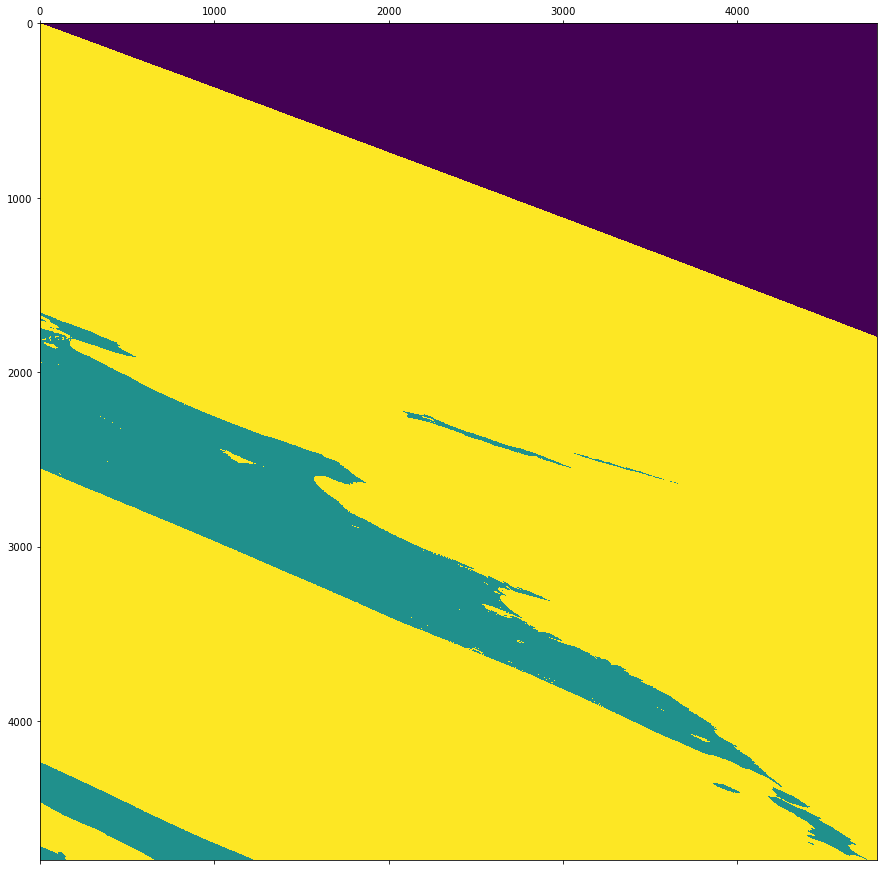

In [44]:
plt.figure(figsize=(15, 15))
plt.matshow(np.where(waterMaskMatrix==250, -1, waterMaskMatrix), fignum=1)

In [45]:
waterMasked = np.where(qaMaskMatrix == 0, waterMaskMatrix, -9999)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

## Truth Raster

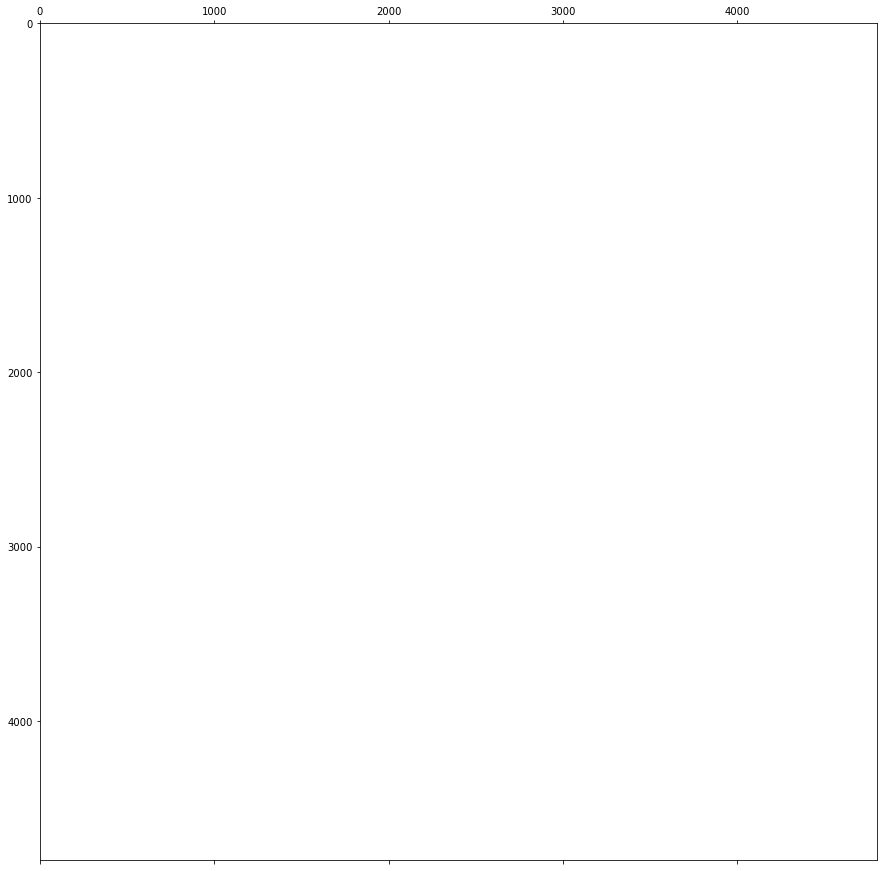

In [46]:
plt.figure(figsize=(15, 15))
truthPlt = plt.matshow(np.where(waterMasked==-9999, np.NaN, waterMasked), fignum=1)
plt.savefig('truthRaster_{}_{}_{}_tabnet.png'.format(YEAR, DAY, TILE))

### Count num of occurences for each class with the water mask

In [47]:
countNoDataT = np.count_nonzero(waterMasked == -9999)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Truth Vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

Truth Vals
 Nodata occurences: 23040000
 Land occurance: 0
 Water occurances: 0


## See bands

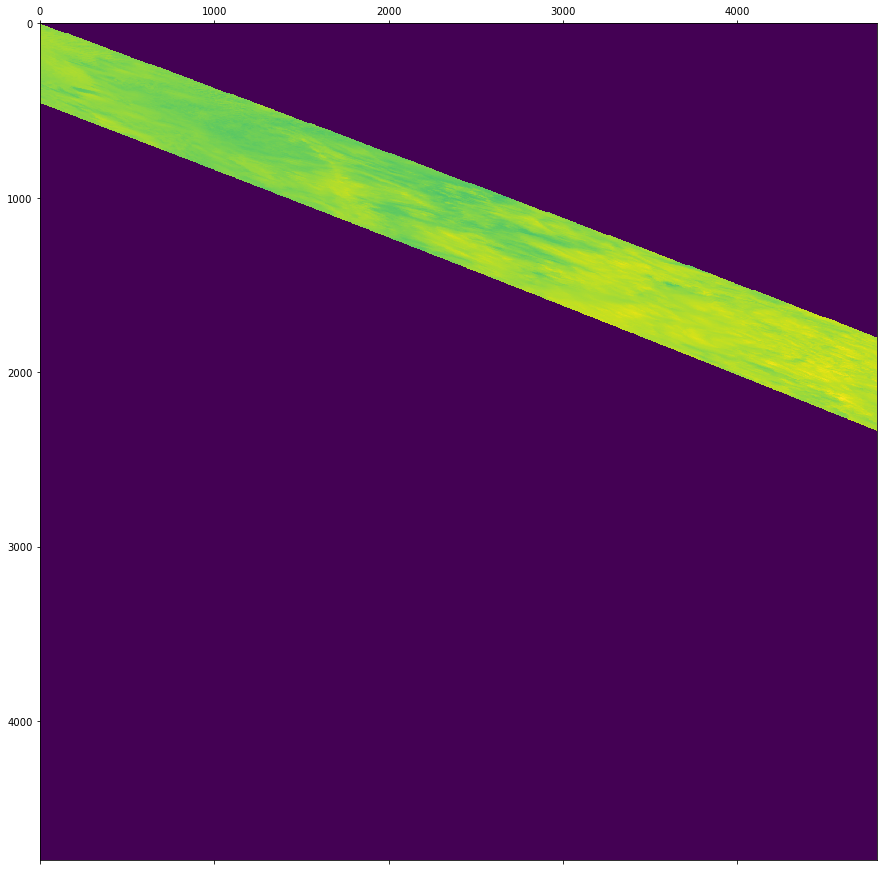

In [48]:
plt.figure(figsize=(15, 15))
plt.matshow(imgWhole[:, :, 0], fignum=1)

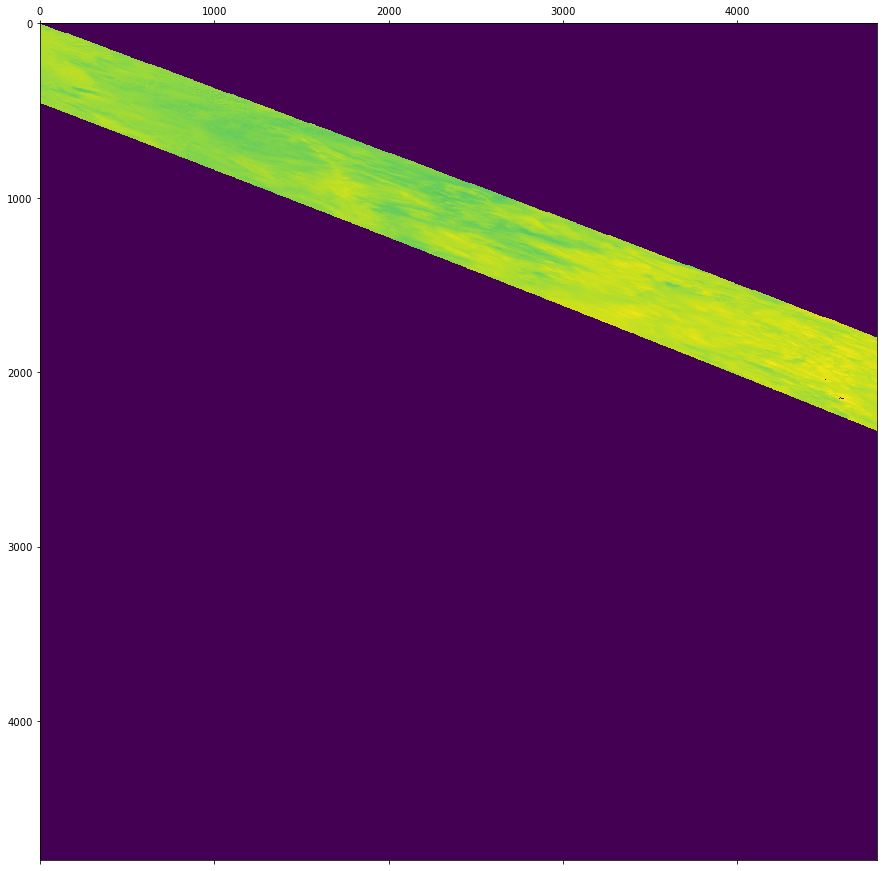

In [49]:
plt.figure(figsize=(15, 15))
plt.matshow(imgWhole[:, :, 1], fignum=1)

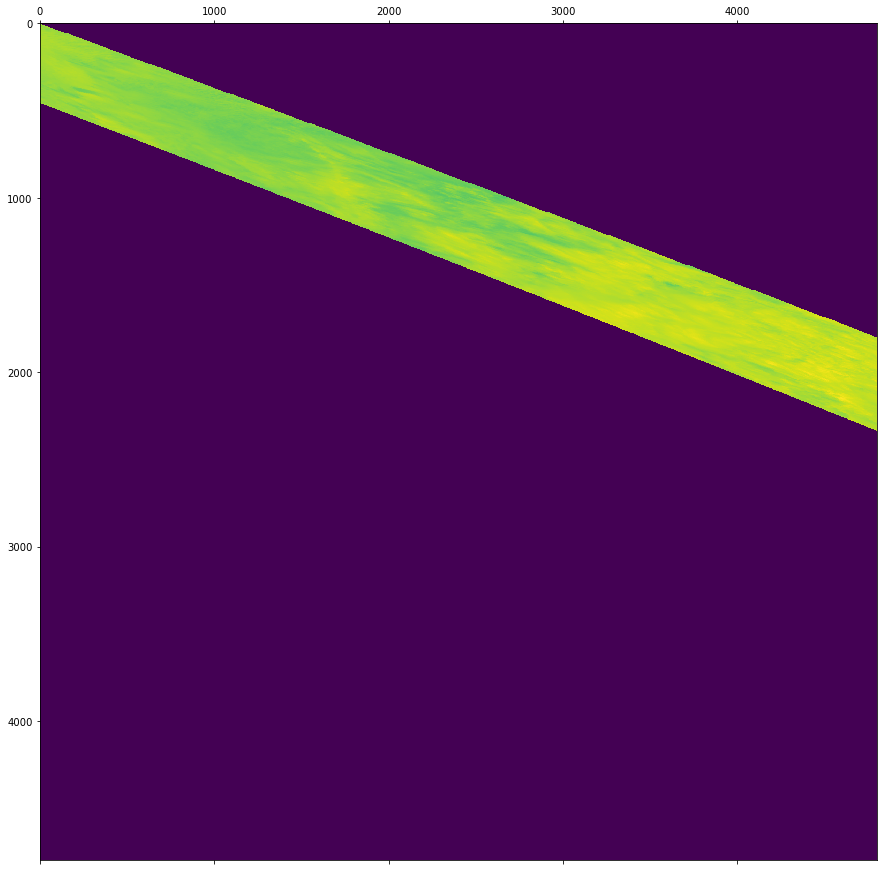

In [50]:
plt.figure(figsize=(15, 15))
plt.matshow(imgWhole[:, :, 2], fignum=1)

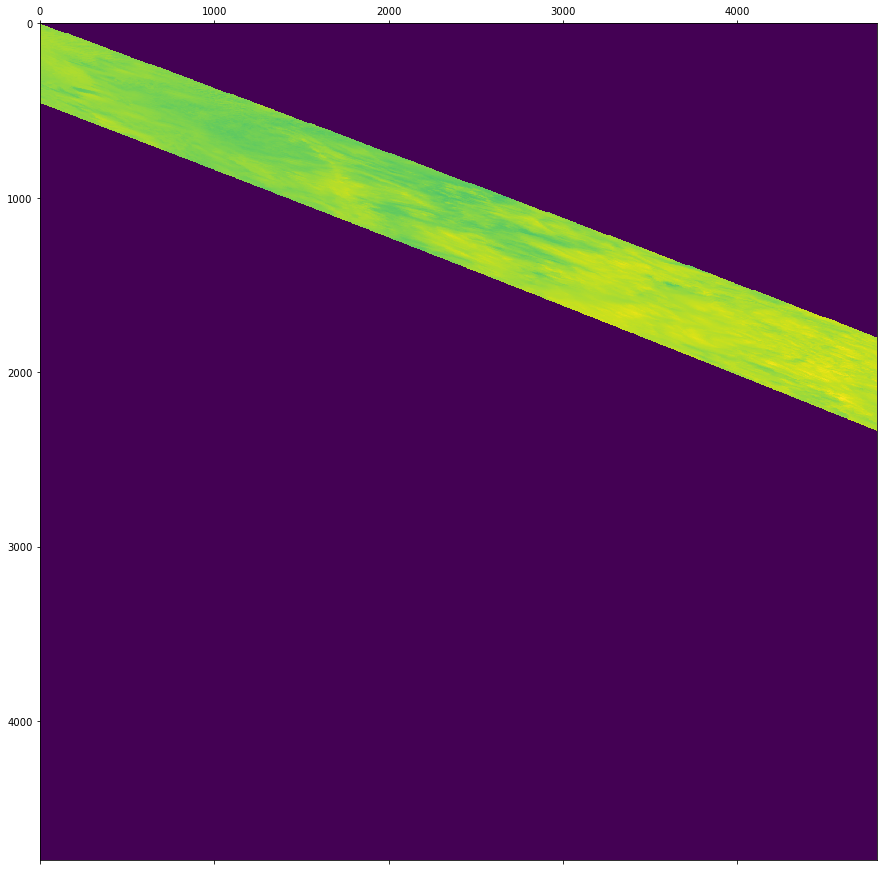

In [51]:
plt.figure(figsize=(15, 15))
plt.matshow(imgWhole[:, :, 3], fignum=1)

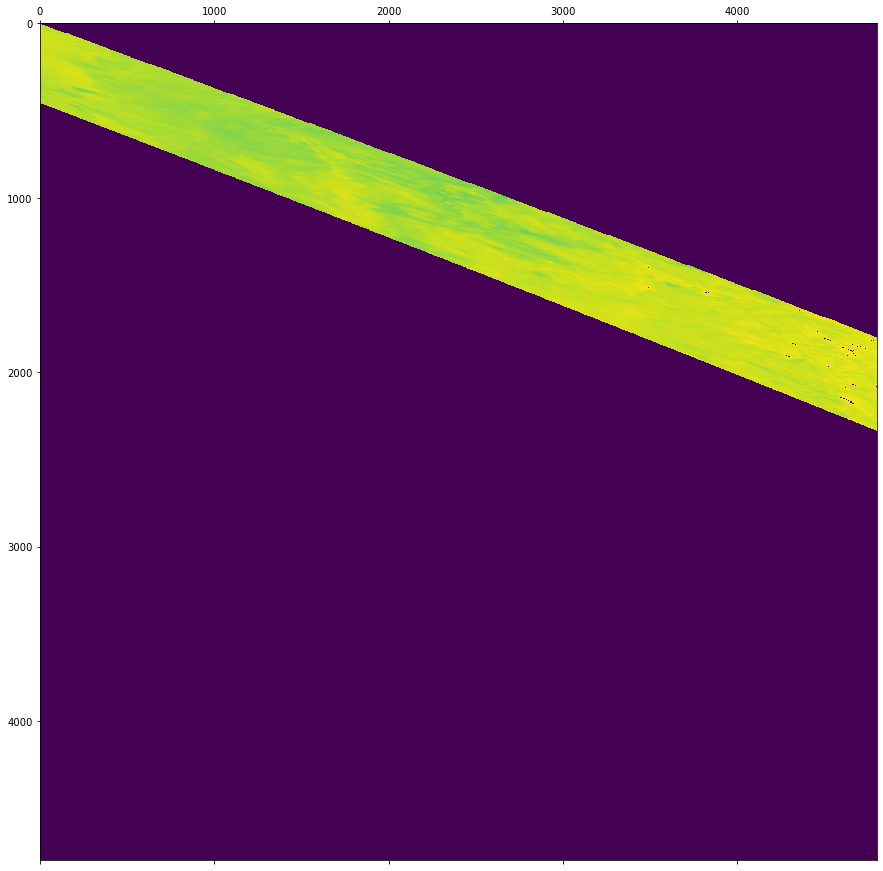

In [52]:
plt.figure(figsize=(15, 15))
plt.matshow(imgWhole[:, :, 4], fignum=1)

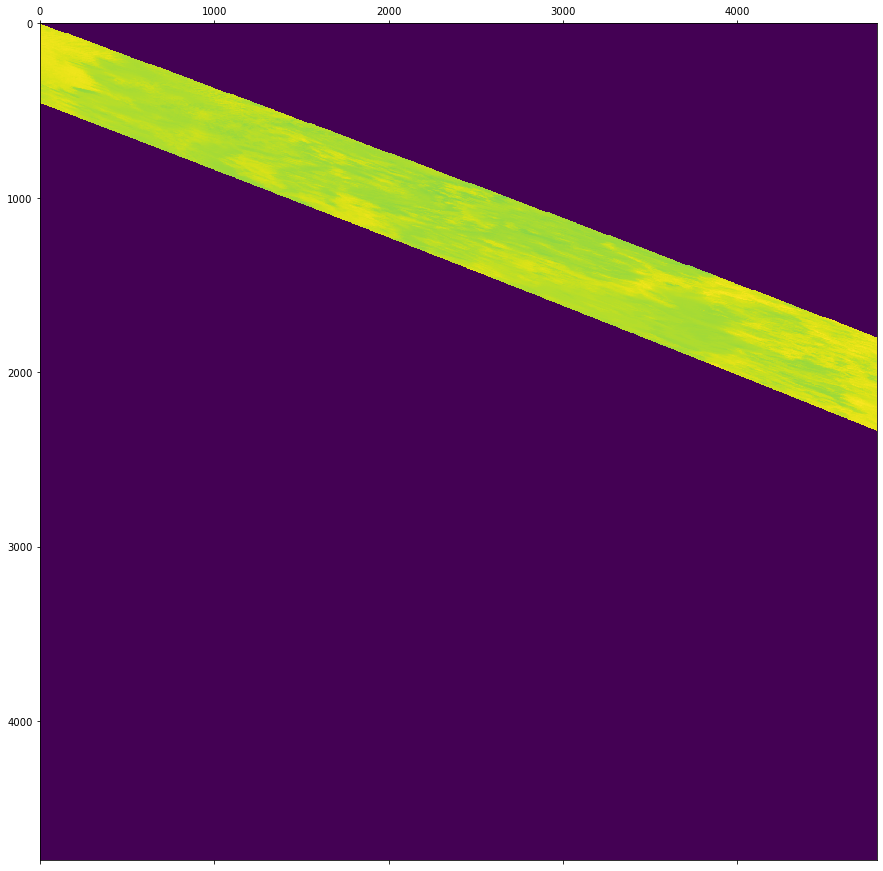

In [53]:
plt.figure(figsize=(15, 15))
plt.matshow(imgWhole[:, :, 5], fignum=1)

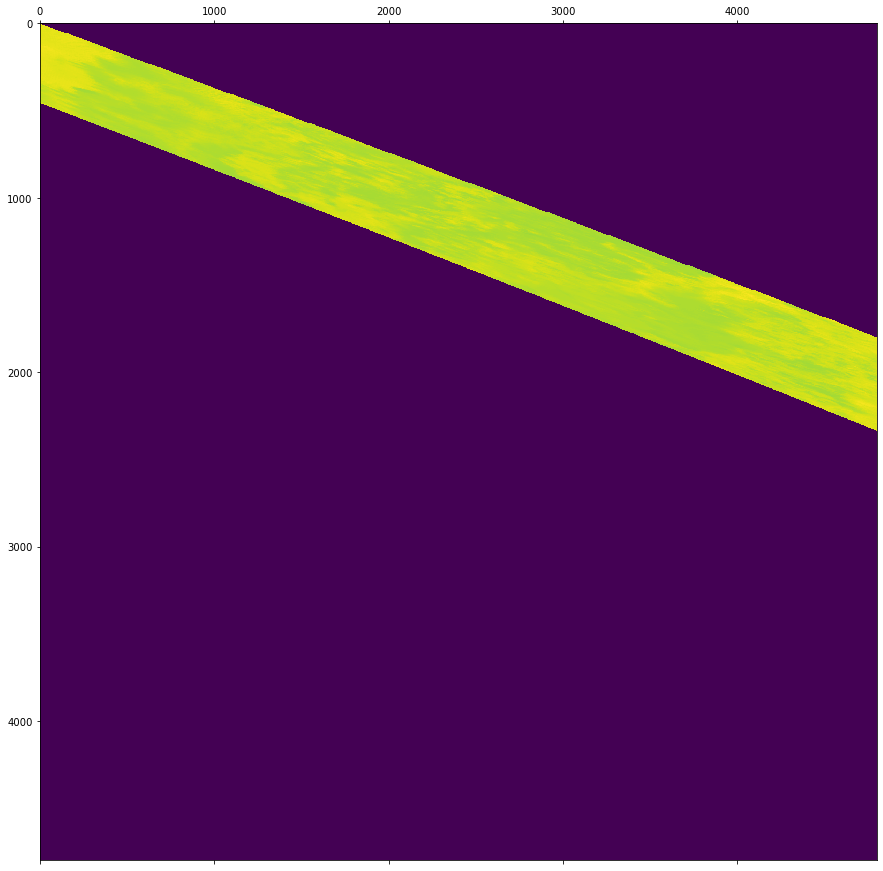

In [54]:
plt.figure(figsize=(15, 15))
plt.matshow(imgWhole[:, :, 6], fignum=1)

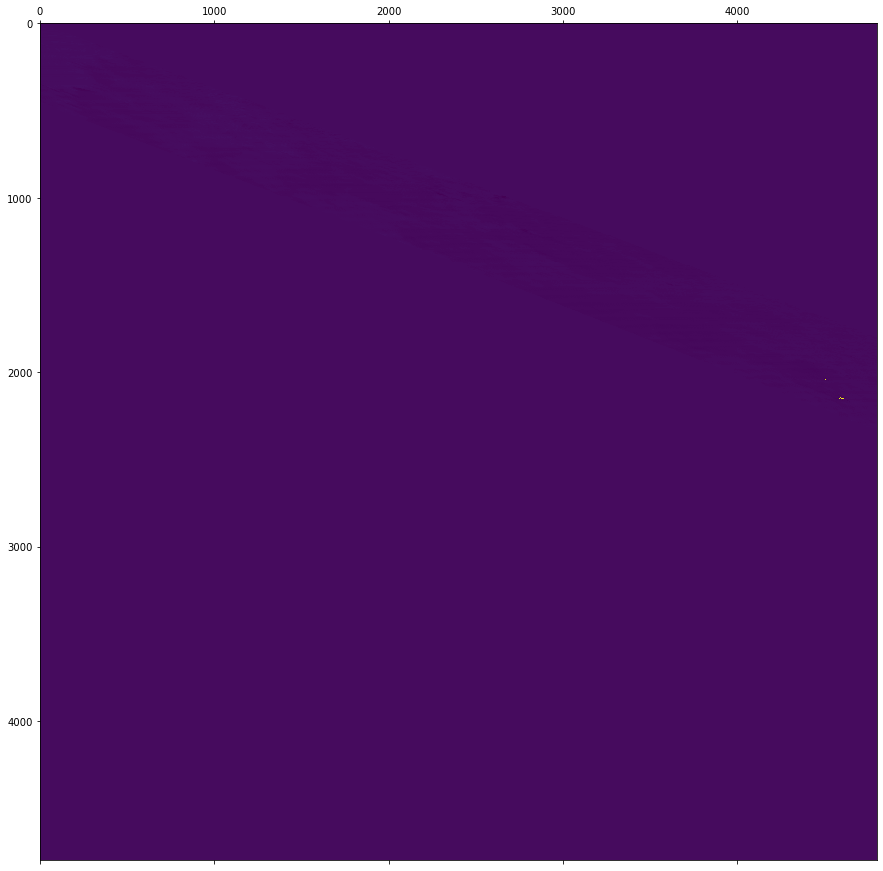

In [55]:
plt.figure(figsize=(15, 15))
plt.matshow(imgWhole[:, :, 7], fignum=1)

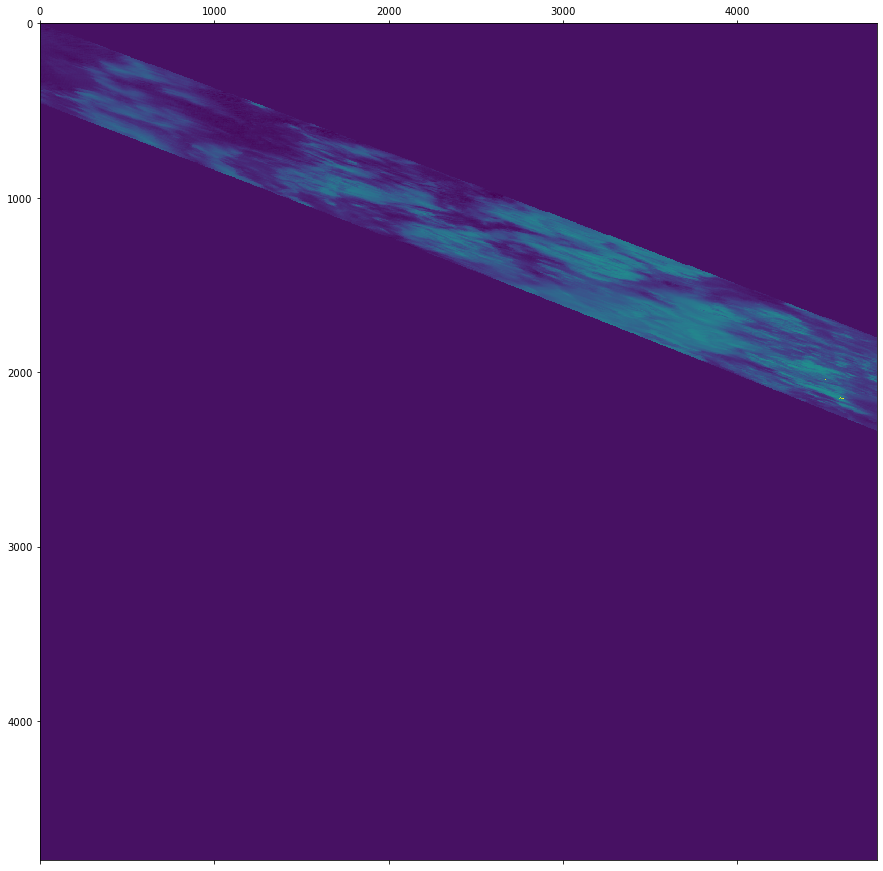

In [56]:
plt.figure(figsize=(15, 15))
plt.matshow(imgWhole[:, :, 8], fignum=1)

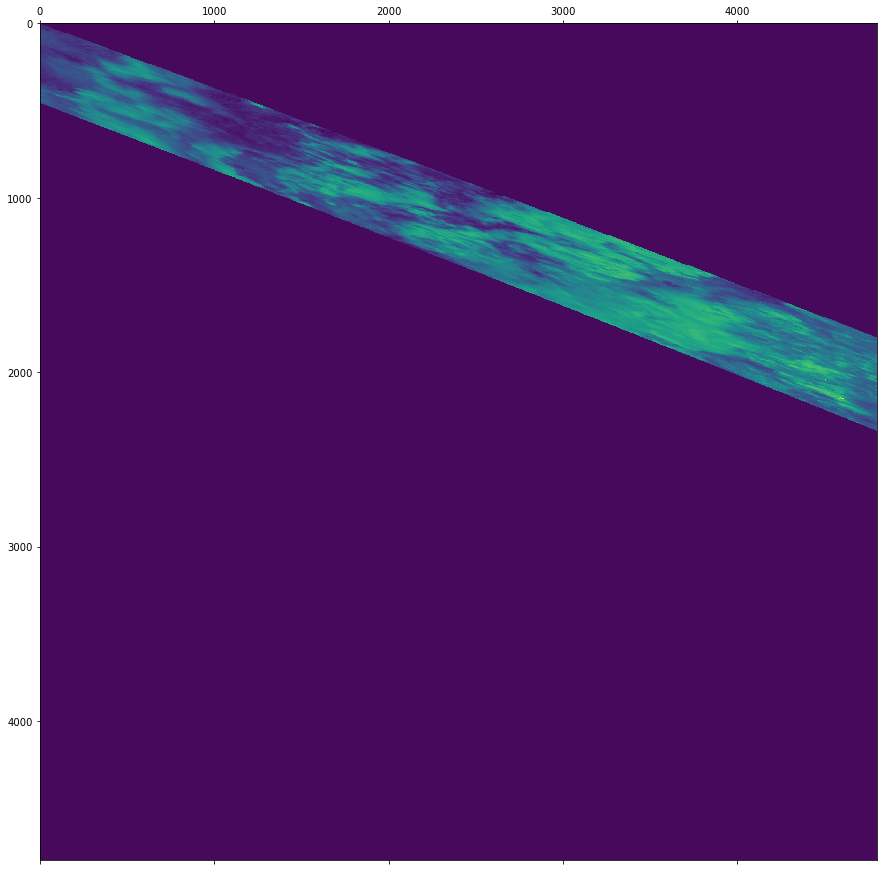

In [57]:
plt.figure(figsize=(15, 15))
plt.matshow(imgWhole[:, :, 9], fignum=1)